In [1]:
# !uv pip install git+https://github.com/PatWalters/rd_filters.git

Using Python 3.10.16 environment at: /home/nikolenko/miniforge/envs/pymol
⠼ Resolving dependencies...                                                     

Resolved 8 packages in 868ms                                         
Audited 8 packages in 0.66ms


100%|██████████| 113/113 [00:00<00:00, 211776.74it/s]


MolGridWidget(grid_id='alerts')

interactive(children=(IntRangeSlider(value=(-6, 0), description='Score', max=0, min=-6), Output()), _dom_class…


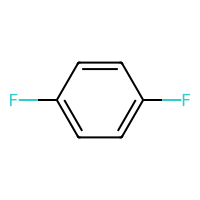
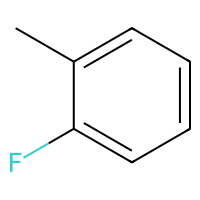
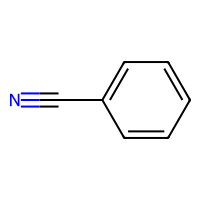
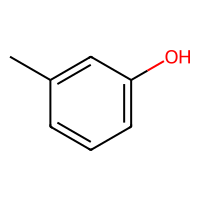
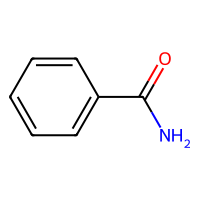
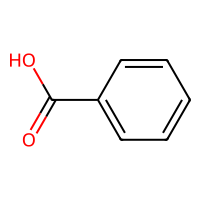
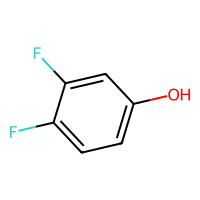
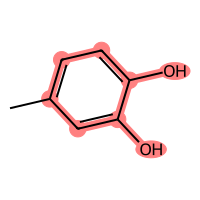
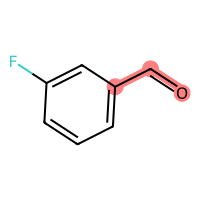
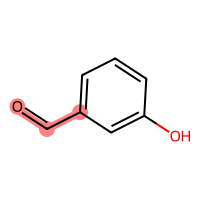
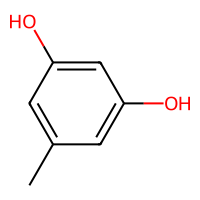
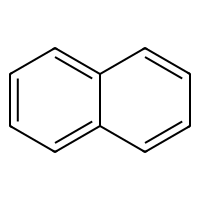
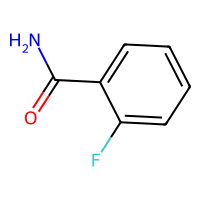
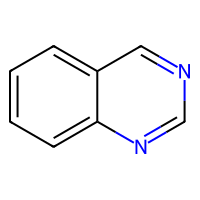
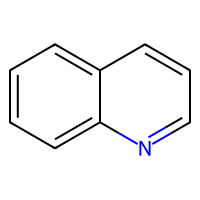
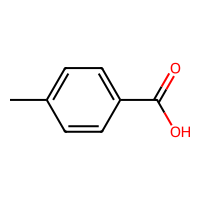
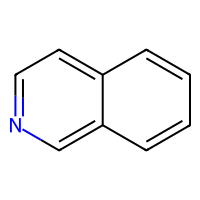
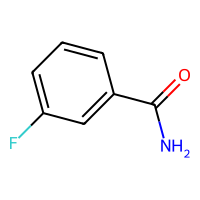
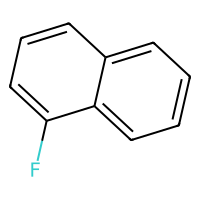
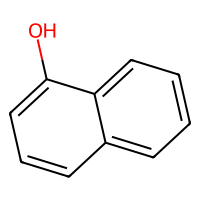
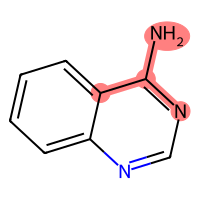
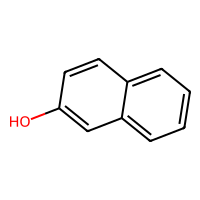
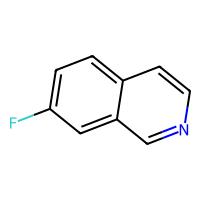
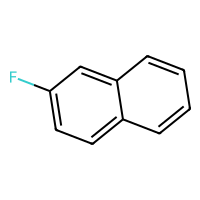
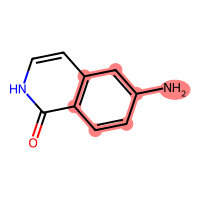
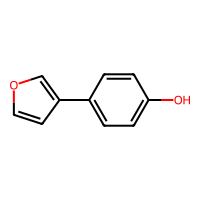
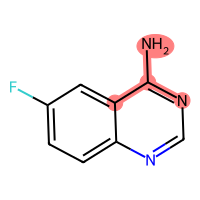
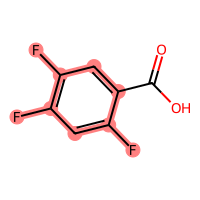
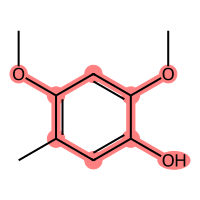
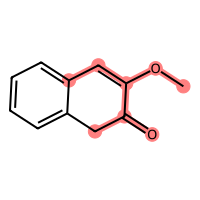
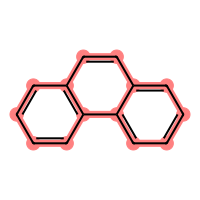
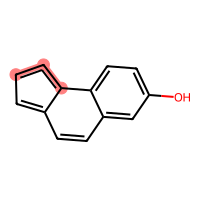
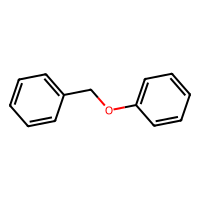
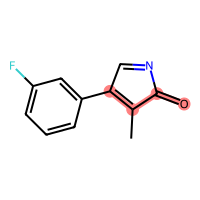
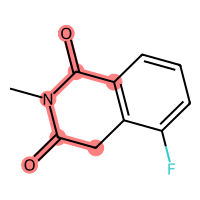
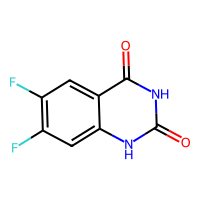
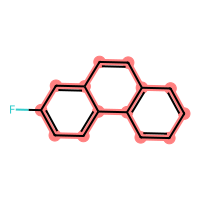
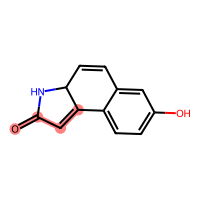
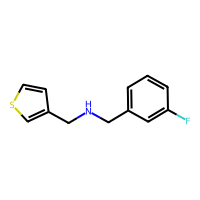
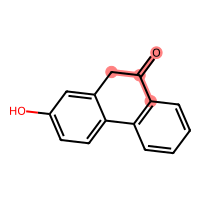
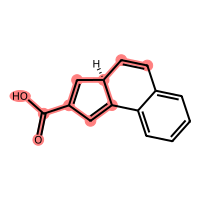
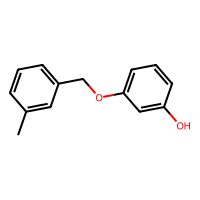
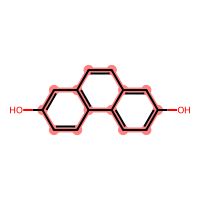
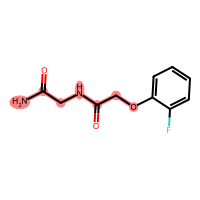
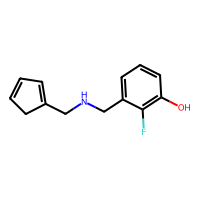
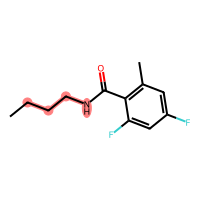
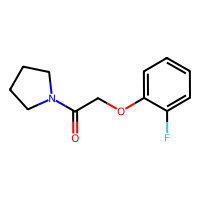
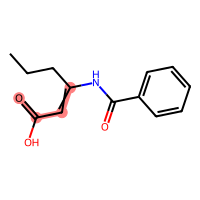
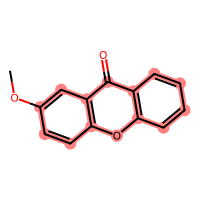
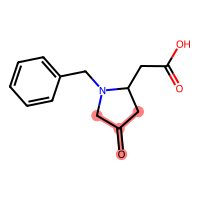
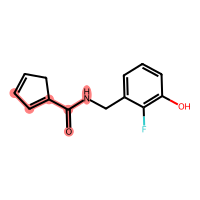
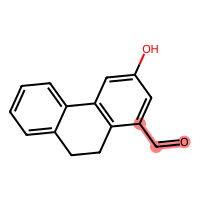
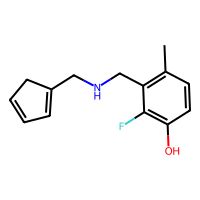
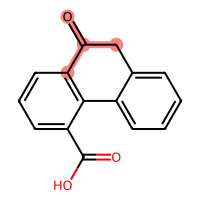
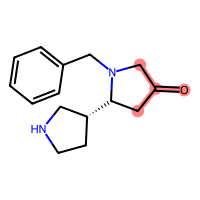
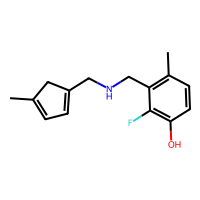
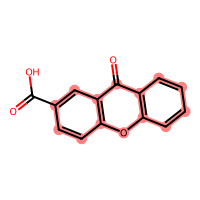
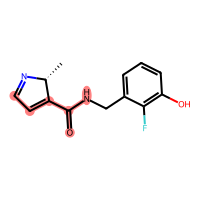
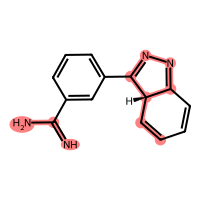
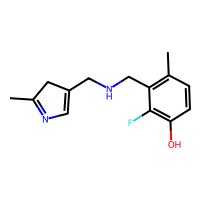
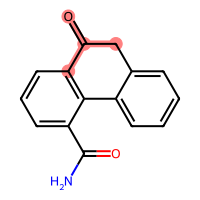
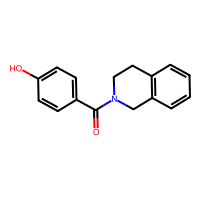
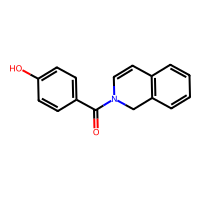
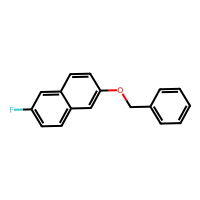
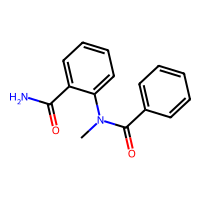
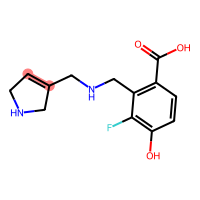
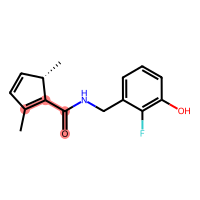
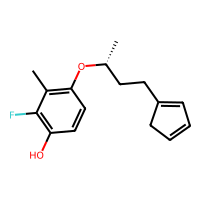
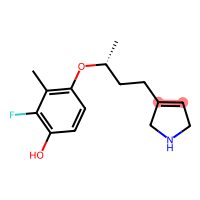
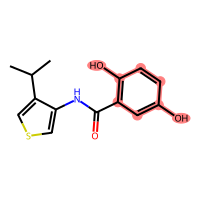
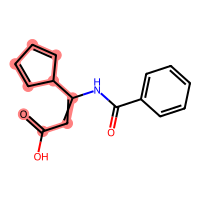
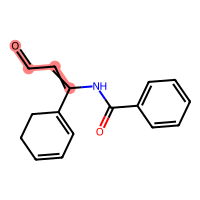
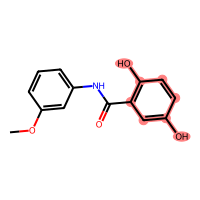
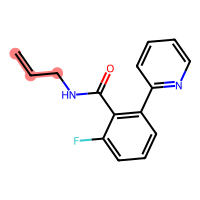
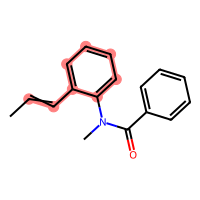
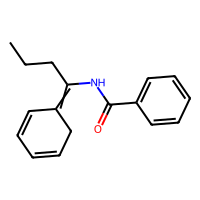
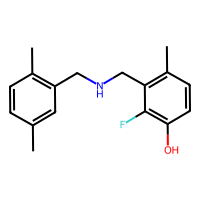
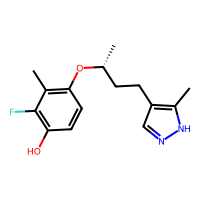
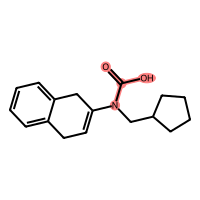
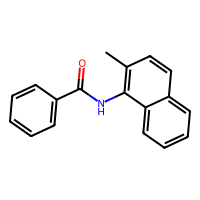
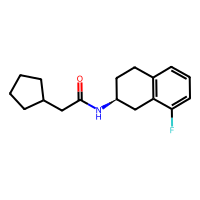
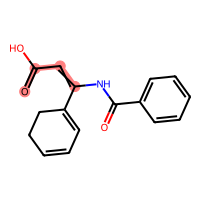
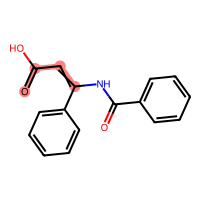
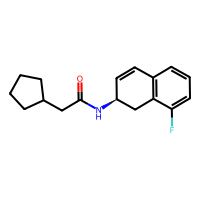
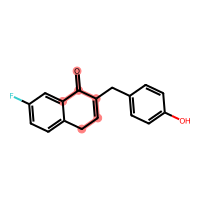
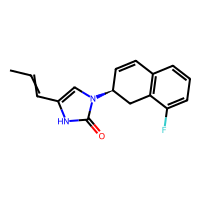
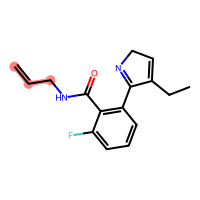
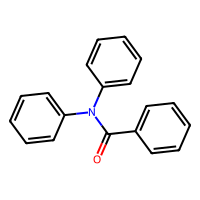
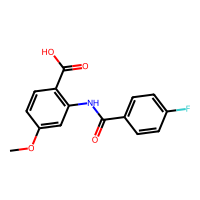
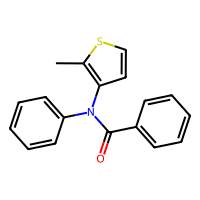
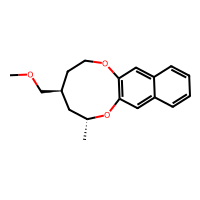
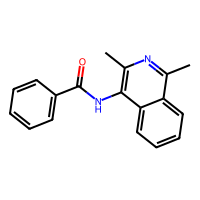
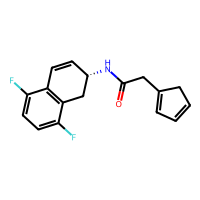
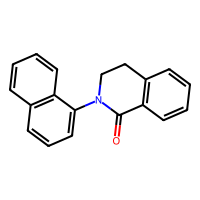
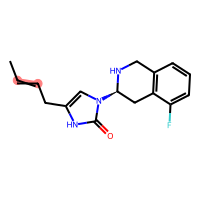
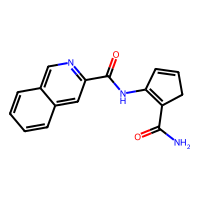
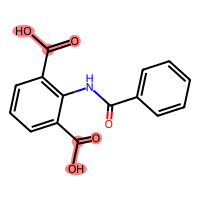
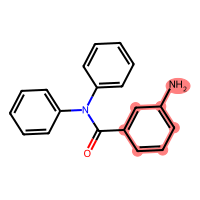
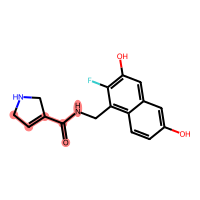
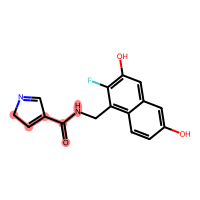
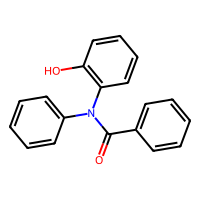
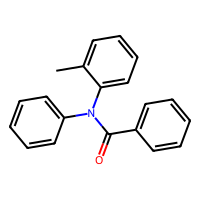
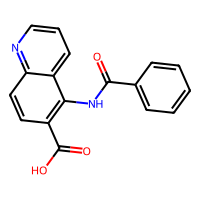
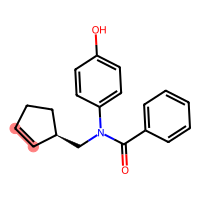
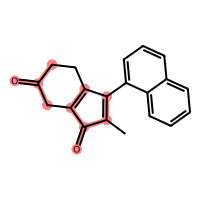
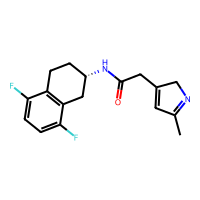
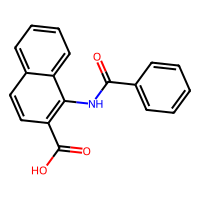
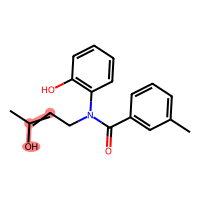
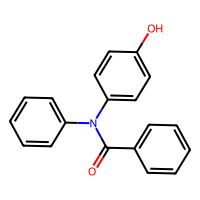
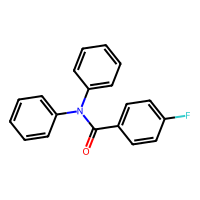
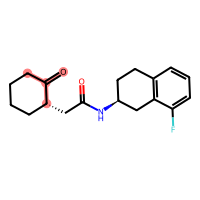
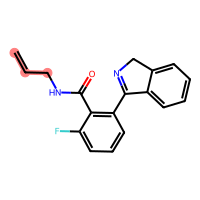
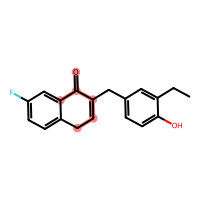

In [2]:
import base64
import io
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
import mols2grid
from IPython.display import display as ipy_display
import datamol as dm
import ipywidgets as widgets
from ipywidgets import interact
from joblib import Parallel, delayed
from tqdm import tqdm

def process_mol_record(mol, use_3d, image_size, alert_filters_dict):
    if not use_3d:
        mol.RemoveAllConformers()
        rdDepictor.Compute2DCoords(mol)
    smiles = dm.to_smiles(mol)
    alert_results = {}
    overall_groups = []
    for rule_set, filters in alert_filters_dict.items():
        triggered_list = []
        groups = []
        for filt in filters:
            matches = mol.GetSubstructMatches(filt["mol"])
            if matches:
                triggered_list.append(filt["name"])
                groups.extend(matches)
        alert_results[rule_set] = ", ".join(triggered_list) if triggered_list else "Passed"
        if groups:
            overall_groups.extend(groups)
    total_score = -sum(1 for v in alert_results.values() if v != "Passed")
    if overall_groups:
        highlight_atoms = set()
        for group in overall_groups:
            highlight_atoms.update(group)
        highlight_atoms = list(highlight_atoms)
        bonds = set()
        for group in overall_groups:
            for bond in mol.GetBonds():
                a1 = bond.GetBeginAtomIdx()
                a2 = bond.GetEndAtomIdx()
                if a1 in group and a2 in group:
                    bonds.add(bond.GetIdx())
        highlight_bonds = list(bonds)
    else:
        highlight_atoms = None
        highlight_bonds = None
    img = Draw.MolToImage(mol, size=image_size, highlightAtoms=highlight_atoms, highlightBonds=highlight_bonds)
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    b64_img = base64.b64encode(buf.getvalue()).decode("utf-8")
    record = {"SMILES": smiles, "Total_Score": total_score, "img": f"<img src='data:image/png;base64,{b64_img}'/>", "mol": mol}
    for rule_set, result in alert_results.items():
        record[rule_set] = result
    return record

class SDFAlertGridViewer:
    def __init__(self, input_source, alert_csv_path, toggles, input_type="sdf", use_3d=False, image_size=(300, 300), grid_size=(60, 50), items_per_page=12):
        self.input_source = input_source
        self.alert_csv_path = alert_csv_path
        self.toggles = toggles
        self.input_type = input_type
        self.use_3d = use_3d
        self.image_size = image_size
        self.grid_size = grid_size
        self.items_per_page = items_per_page
        self.df = None
        self.alert_filters_dict = {}
        self.load_alert_filters(alert_csv_path, toggles)
        
    def load_alert_filters(self, alert_csv_path, toggles):
        df = pd.read_csv(alert_csv_path)
        active_df = df[df["rule_set_name"].apply(lambda x: toggles.get("Rule_" + x, False))]
        for _, row in active_df.iterrows():
            rule_set = row["rule_set_name"]
            if rule_set not in self.alert_filters_dict:
                self.alert_filters_dict[rule_set] = []
            mol_filter = Chem.MolFromSmarts(row["smarts"])
            if mol_filter:
                self.alert_filters_dict[rule_set].append({"name": row["description"], "mol": mol_filter})
                
    def get_mols(self):
        if self.input_type == "sdf":
            supplier = Chem.SDMolSupplier(self.input_source)
            return [m for m in supplier if m is not None]
        elif self.input_type == "mols":
            return self.input_source
        elif self.input_type == "smiles":
            mols = []
            for smi in self.input_source:
                mol = Chem.MolFromSmiles(smi)
                if mol:
                    mols.append(mol)
            return mols
        return []
    
    def process_input(self):
        mols = self.get_mols()
        records = Parallel(n_jobs=-1, backend="threading")(
            delayed(process_mol_record)(mol, self.use_3d, self.image_size, self.alert_filters_dict) for mol in tqdm(mols)
        )
        self.df = pd.DataFrame(records)
        return self.df
    
    def display_grid(self):
        if self.df is None:
            print("DataFrame is empty, run process_input() first.")
            return
        alert_cols = list(self.alert_filters_dict.keys())
        grid = mols2grid.MolGrid(
            self.df,
            smiles_col="SMILES",
            mol_col="mol",
            subset=alert_cols + ["Total_Score"],
            tooltip=["SMILES"] + alert_cols + ["Total_Score"],
            size=self.grid_size,
            name="alerts",
            prerender=True
        )
        grid.mol_to_img = lambda m: self.df.loc[self.df["SMILES"] == dm.to_smiles(m), "img"].iloc[0]
        grid._prepare_dataframe(grid.dataframe)
        min_score = self.df["Total_Score"].min()
        max_score = self.df["Total_Score"].max()
        def filter_grid(Score):
            results = grid.dataframe.query("(@Score[0] <= Total_Score <= @Score[1])")
            return grid.filter_by_index(results.index)
        interact(filter_grid, Score=widgets.IntRangeSlider(value=[min_score, max_score], min=min_score, max=max_score, step=1))
        style = {col: (lambda x: "color: red; font-weight: bold;" if x != "Passed" else "") for col in alert_cols}
        grid_view = grid.display(n_items_per_page=self.items_per_page, style=style)
        ipy_display(grid_view)
    
    def show(self, image_size=None, grid_size=None, items_per_page=None):
        if image_size:
            self.image_size = image_size
        if grid_size:
            self.grid_size = grid_size
        if items_per_page:
            self.items_per_page = items_per_page
        self.process_input()
        self.display_grid()

toggles = {
    "Rule_BMS": True,           
    "Rule_Dundee": True,        
    "Rule_Glaxo": True,         
    "Rule_Inpharmatica": True,  
    "Rule_LINT": True,          
    "Rule_MLSMR": True,         
    "Rule_PAINS": True,         
    "Rule_SureChEMBL": True     
}

viewer = SDFAlertGridViewer("6gj7_F0B_ligand_gen.sdf", "data/alert_collection.csv", 
                            toggles, input_type="sdf", 
                            use_3d=False,
                            image_size=(200, 200),
                            grid_size=(100, 80))
viewer.show()

# Описание фильтров

Ниже приведён перечень фильтров, используемых для оценки молекул, с кратким описанием их назначения:

- **Rule_BMS**  
  Фильтр, разработанный на основе набора правил компании Bristol-Myers Squibb. Отвечает за выявление структурных элементов, которые могут указывать на реакционноспособные или токсичные фрагменты, потенциально вызывающие проблемы на этапах разработки лекарственного кандидата.

- **Rule_Dundee**  
  Основан на правилах, сформированных исследовательской группой Dundee. Предназначен для обнаружения функциональных групп или субструктур, ассоциированных с нежелательной реакционной активностью или нестабильностью молекул.

- **Rule_Glaxo**  
  Фильтр, разработанный с учётом опыта компании GlaxoSmithKline. Помогает выявлять молекулы, содержащие проблемные химические мотивы, способные приводить к ложноположительным результатам в скрининговых системах или вызывать нежелательные реакции в биологических системах.

- **Rule_Inpharmatica**  
  Правила данного фильтра направлены на обнаружение структурных фрагментов, часто встречающихся в неудачных лекарственных соединениях. Фильтр позволяет исключить молекулы с потенциально реакционноспособными или нестабильными группами, способными негативно влиять на биологическую активность.

- **Rule_LINT**  
  Проверяет молекулы на наличие типичных структурных проблем, связанных с физико-химическими параметрами, синтетической доступностью или соответствием лидерам соединений. Его задача — выявить соединения, которые могут оказаться менее пригодными для дальнейшей оптимизации.

- **Rule_MLSMR**  
  Фильтр, основанный на анализе молекул из репозитория MLSMR (Molecular Libraries Small Molecule Repository). Предназначен для выявления субструктур, исторически ассоциированных с ложными срабатываниями или нежелательными свойствами в молекулах, включённых в данный набор.

- **Rule_PAINS**  
  Один из наиболее известных фильтров, выявляющий так называемые Pan-Assay INterference compounds (PAINS). Эти молекулы часто дают ложноположительные результаты в биологических тестах из-за неспецифического взаимодействия или повышенной реакционной активности, что может приводить к неверным выводам при скрининге.

- **Rule_SureChEMBL**  
  Фильтр, использующий данные из базы SureChEMBL, которая собирает химическую информацию из патентных документов. Помогает обнаружить соединения с патентными или химическими особенностями, вызывающими опасения в плане стабильности, селективности или потенциальных проблем при патентовании.